In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
'''
im = cv2.imread("rick1.jpg")
#im.resize(512,512)
im = cv2.resize(im, (512,512))
cv2.imwrite("rick.jpg",im)
'''

'\nim = cv2.imread("rick1.jpg")\n#im.resize(512,512)\nim = cv2.resize(im, (512,512))\ncv2.imwrite("rick.jpg",im)\n'

In [2]:
#PSNR（峰值信噪比）计算时把矩阵类型转换为float型，更精确，避免开根号操作
def PSNR(I,K):
    return 10*(np.log((255*255)/((I.astype(np.float)-K)**2).mean()))/np.log(10)

#将图像元素类型转换为 uin8
def float2uint8(I):
    return np.clip(I, 0, 255).astype(np.uint)


#显示图片
def plot_img(I):
   
    plt.figure(figsize = [10,8])
    plt.xticks([])
    plt.yticks([])
    plt.axis("off")
   
    plt.imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
    plt.show()

#相似度比较块，搜索区域内的滑动块，用kernel表示，用于求W
def make_kernel(f):
    kernel = np.zeros((2*f+1, 2*f+1))
    for d in range(1, f+1):
        kernel[f-d:f+d+1, f-d:f+d+1] += (1.0/((2*d+1)**2))
    return kernel/kernel.sum()    


#搜索区域在图像上滑动，kernel在搜索区域上滑动
def NLmeansfilter(I, h_=10, templateWindowSize=5,  searchWindowSize=11):
    
    f = templateWindowSize//2
    t = searchWindowSize//2
    height, width = I.shape[:2]
    padLength = t+f
    
    
    I2 = np.pad(I,((padLength,padLength),(padLength,padLength),(0,0)) , 'symmetric')
    kernel = make_kernel(f)
    
    h = (h_**2)
    I_ = I2[padLength-f:padLength+f+height, padLength-f:padLength+f+width]
  
    average = np.zeros(I.shape)
    sweight = np.zeros(I.shape)
    wmax =  np.zeros(I.shape)
    
    for i in range(-t, t+1):
        for j in range(-t, t+1):
            if i==0 and j==0:
                continue
            I2_ = I2[padLength+i-f:padLength+i+f+height, padLength+j-f:padLength+j+f+width]
            
            #求相似度系数W
            w = np.exp(-cv2.filter2D((I2_ - I_)**2, -1, kernel)/h)[f:f+height, f:f+width]
            sweight += w 
            
            wmax = np.maximum(wmax, w)
            average += (w*I2_[f:f+height, f:f+width])
            
    return (average+wmax*I)/(sweight+wmax)     #加权求和

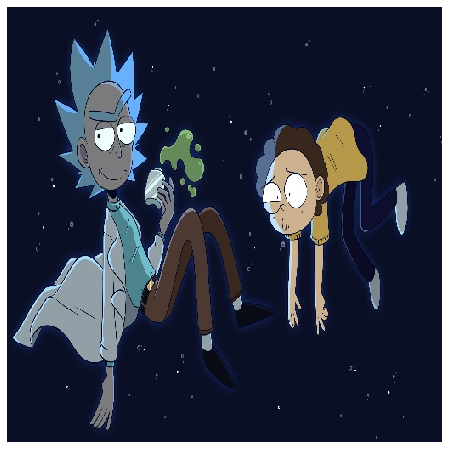

In [3]:
#原图
I = cv2.imread("rick.jpg")

#OpenCV 默认BGR模式，要转换成RGB在matplotlib中显示
plot_img(I)

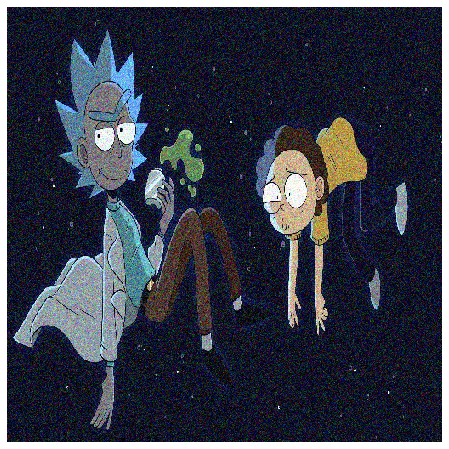

In [4]:
sigma = 30.0
I1 = float2uint8(I+np.random.randn(*I.shape)*sigma)
plot_img(I1.astype(np.uint8))

中值滤波PSNR 24.026196 dB


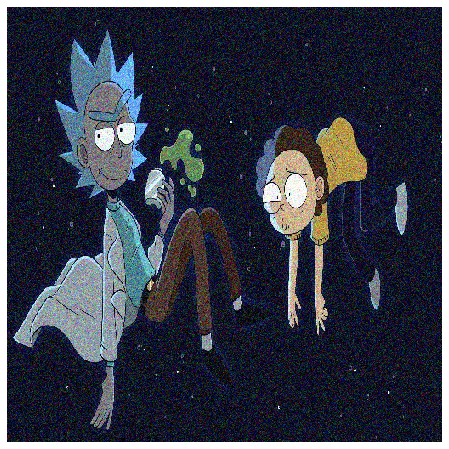

In [5]:
R1  = cv2.medianBlur(I1.astype(np.uint8), 5)
print('中值滤波PSNR %f dB'%PSNR(I, R1))
plot_img(I1.astype(np.uint8))

opencv的NLM算法 28.984580 dB


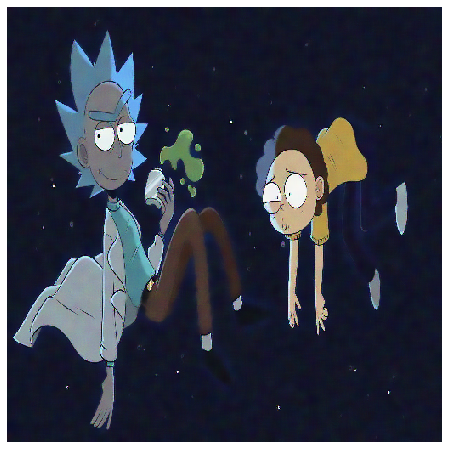

In [6]:
R2 = cv2.fastNlMeansDenoising(I1.astype(np.uint8), None, sigma, 5, 11)
print ('opencv的NLM算法 %f dB'%PSNR(I, R2))
plot_img(R2)

opencv的NLM算法 28.731615 dB


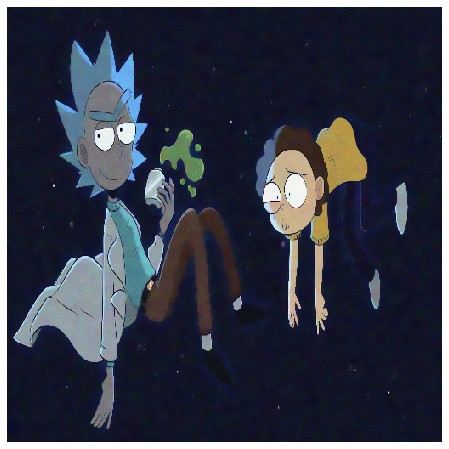

In [8]:
R3 = float2uint8(NLmeansfilter(I1.astype(np.float), sigma, 5, 11))
print ('opencv的NLM算法 %f dB'%PSNR(I, R3))
plot_img(R3.astype(np.uint8))